# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


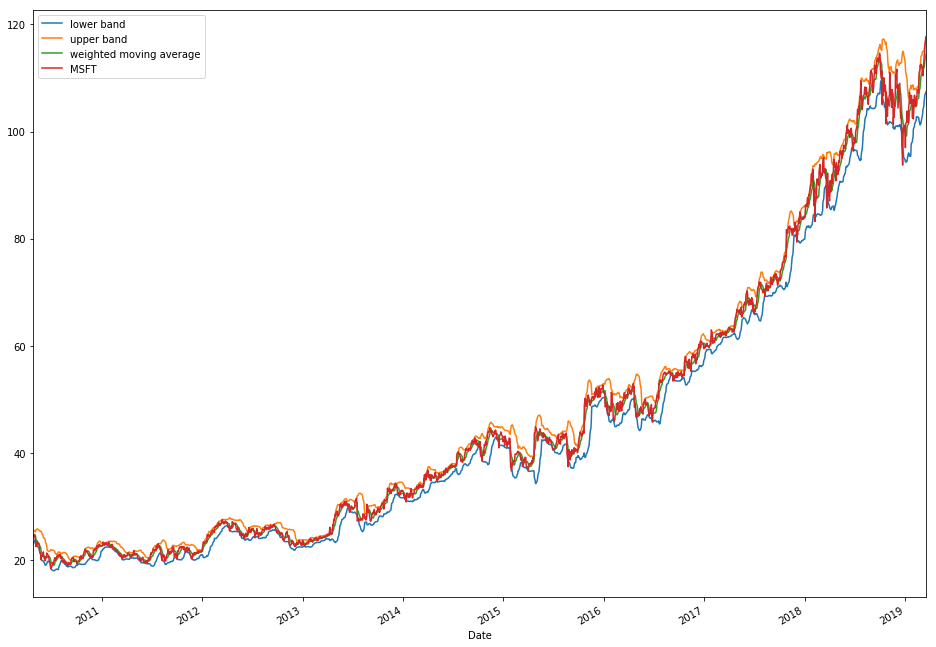

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

normalized_stock_list = []
y_adj_close_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
    y_adj_close_list.append(stock_data[adjclose])
    stock_data = stock_data.drop(columns=adjclose)
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    normalized_stock_list.append(scaled_df)

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
for y_adj_close in y_adj_close_list:
    y_adj_close.shift(-1)




    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


Date
2010-04-27     24.651001
2010-04-28     24.698944
2010-04-29     24.770861
2010-04-30     24.403294
2010-05-03     24.658993
2010-05-04     24.075682
2010-05-05     23.851942
2010-05-06     23.156761
2010-05-07     22.541483
2010-05-10     23.124798
2010-05-11     23.076849
2010-05-12     23.524330
2010-05-13     23.364517
2010-05-14     23.116808
2010-05-17     23.124798
2010-05-18     22.956236
2010-05-19     22.667269
2010-05-20     21.760265
2010-05-21     21.543539
2010-05-24     21.086029
2010-05-25     20.925493
2010-05-26     20.074663
2010-05-27     20.869303
2010-05-28     20.708771
2010-06-01     20.781010
2010-06-02     21.238535
2010-06-03     21.559595
2010-06-04     20.700745
2010-06-07     20.299412
2010-06-08     20.154936
                 ...    
2019-02-05    106.764046
2019-02-06    105.579102
2019-02-07    104.822327
2019-02-08    105.220634
2019-02-11    104.802422
2019-02-12    106.435448
2019-02-13    106.355782
2019-02-14    106.445404
2019-02-15    107.75

/home/omer/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


Using TensorFlow backend.


In [8]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model
       

In [15]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    linear_reg_predictions = []
    svm_linear_predictions = []
    svm_poly_predictions = []
    lstm_predictions = []
    y_actuals = []
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                                            y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =10,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)
        linear_reg_predictions.append(linear_y_predict)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)
        svm_linear_predictions.append(svm_linear_y_predict)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)
        svm_poly_predictions.append(svm_polynomial_y_predict)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 10)
        lstm_y_predict = lstm_model.predict(testX)
        lstm_predictions.append(lstm_y_predict)


        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[0])

        results_dataframe = results_dataframe.append(df)
        y_actuals.append(y_test)
    return results_dataframe, linear_reg_predictions, svm_linear_predictions, \
                svm_poly_predictions, lstm_predictions, y_actuals

In [16]:
results_different_models, linear_reg_predictions, svm_linear_predictions, \
svm_poly_predictions, lstm_predictions, y_actuals = drive_test(True)
#result_same_models = drive_test(False)

Epoch 1/10
1791/1791 [==============================] - 4s 2ms/step - loss: 254.9442 - acc: 0.0000e+00
Epoch 2/10
1791/1791 [==============================] - 0s 32us/step - loss: 9.1480 - acc: 0.0000e+00
Epoch 3/10
1791/1791 [==============================] - 0s 29us/step - loss: 8.7614 - acc: 0.0000e+00
Epoch 4/10
1791/1791 [==============================] - 0s 31us/step - loss: 8.5862 - acc: 0.0000e+00
Epoch 5/10
1791/1791 [==============================] - 0s 32us/step - loss: 8.2420 - acc: 0.0000e+00
Epoch 6/10
1791/1791 [==============================] - 0s 32us/step - loss: 7.9328 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 29us/step - loss: 7.9349 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [==============================] - 0s 32us/step - loss: 7.5972 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 28us/step - loss: 7.5214 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 29us/step - loss: 7.1

1791/1791 [==============================] - 0s 76us/step - loss: 125.4633
Epoch 6/10
1791/1791 [==============================] - 0s 74us/step - loss: 46.0607
Epoch 7/10
1791/1791 [==============================] - 0s 71us/step - loss: 17.4619
Epoch 8/10
1791/1791 [==============================] - 0s 72us/step - loss: 10.9462
Epoch 9/10
1791/1791 [==============================] - 0s 70us/step - loss: 7.9297
Epoch 10/10
1791/1791 [==============================] - 0s 72us/step - loss: 6.6988
Linear Regression RMSE Score: 0.42911943454942464
Linear Regression R2 Score: 0.9979129525327048
SVM Linear Model RMSE Score: 0.3184308419055701
SVM Linear Model R2 Score: 0.9988507719726042
SVM Polynomial Model RMSE Score: 0.18069471839249301
SVM Polynomial Model R2 Score: 0.9996299444892462
LSTM Model RMSE Score: 1.2208737735068054
LSTM Model R2 Score: 0.9831065835704325
3
Epoch 1/10
1791/1791 [==============================] - 5s 3ms/step - loss: 217.3782 - acc: 0.0000e+00
Epoch 2/10
1791/1791

1791/1791 [==============================] - 0s 32us/step - loss: 1.4111 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 34us/step - loss: 1.1437 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [==============================] - 0s 34us/step - loss: 0.9421 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 32us/step - loss: 0.7925 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 34us/step - loss: 0.7422 - acc: 0.0000e+00
Epoch 1/10
1791/1791 [==============================] - 6s 3ms/step - loss: 4343.1120
Epoch 2/10
1791/1791 [==============================] - 0s 76us/step - loss: 3976.3383
Epoch 3/10
1791/1791 [==============================] - 0s 77us/step - loss: 3473.8101
Epoch 4/10
1791/1791 [==============================] - 0s 75us/step - loss: 2898.1219
Epoch 5/10
1791/1791 [==============================] - 0s 78us/step - loss: 2309.5405
Epoch 6/10
1791/1791 [==============================] - 0s 77us/st

Epoch 1/10
1791/1791 [==============================] - 6s 3ms/step - loss: 128.4345 - acc: 0.0000e+00
Epoch 2/10
1791/1791 [==============================] - 0s 36us/step - loss: 0.5118 - acc: 0.0000e+00
Epoch 3/10
1791/1791 [==============================] - 0s 38us/step - loss: 0.4971 - acc: 0.0000e+00
Epoch 4/10
1791/1791 [==============================] - 0s 38us/step - loss: 0.5143 - acc: 0.0000e+00
Epoch 5/10
1791/1791 [==============================] - 0s 37us/step - loss: 0.5027 - acc: 0.0000e+00
Epoch 6/10
1791/1791 [==============================] - 0s 38us/step - loss: 0.5021 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 38us/step - loss: 0.4794 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [==============================] - 0s 37us/step - loss: 0.4755 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 37us/step - loss: 0.4816 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 37us/step - loss: 0.4

In [11]:
display(results_different_models)
display(result_same_models)

,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,2.182904,0.998150,2.004182,0.998440,0.839159,0.999727,8.693726,0.970655
0,7.934008,0.999717,5.369823,0.999871,6.121477,0.999832,21.815776,0.997864
0,2.165323,0.999314,1.878048,0.999484,1.024915,0.999846,4.598911,0.996906
0,0.368892,0.998458,0.318431,0.998851,0.180695,0.999630,1.776345,0.964237
0,0.977493,0.999661,0.537153,0.999898,0.381595,0.999948,2.256318,0.998193
0,0.511479,0.999606,0.354377,0.999811,0.268849,0.999891,1.102744,0.998167
0,1.331352,0.999678,0.274242,0.999986,0.400191,0.999971,3.065477,0.998295
0,0.698161,0.998241,0.659137,0.998432,0.438073,0.999308,5.862604,0.875987
0,0.265443,0.998980,0.242498,0.999149,0.174377,0.999560,2.821255,0.884789
0,0.798198,0.992257,0.729150,0.993539,0.483466,0.997159,4.487562,0.755252


,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,2.133523,0.998233,2.004182,0.998440,0.839159,0.999727,8.071992,0.974702
0,8.100578,0.999705,5.369823,0.999871,6.121477,0.999832,23.512750,0.997518
0,2.032298,0.999396,1.878048,0.999484,1.024915,0.999846,4.455839,0.997096
0,0.380677,0.998358,0.318431,0.998851,0.180695,0.999630,1.916103,0.958388
0,0.925733,0.999696,0.537153,0.999898,0.381595,0.999948,2.266851,0.998176
0,0.506956,0.999613,0.354377,0.999811,0.268849,0.999891,1.134423,0.998060
0,1.295369,0.999696,0.274242,0.999986,0.400191,0.999971,2.845343,0.998531
0,0.659694,0.998430,0.659137,0.998432,0.438073,0.999308,5.100175,0.906145
0,0.287635,0.998802,0.242498,0.999149,0.174377,0.999560,2.808843,0.885801
0,0.797380,0.992273,0.729150,0.993539,0.483466,0.997159,3.606627,0.841911


ValueError: x and y must have same first dimension, but have shapes (1,) and (448,)

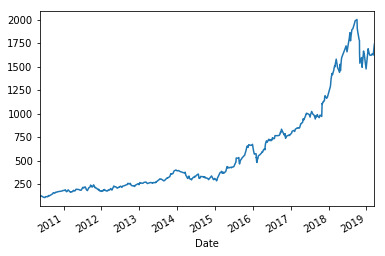

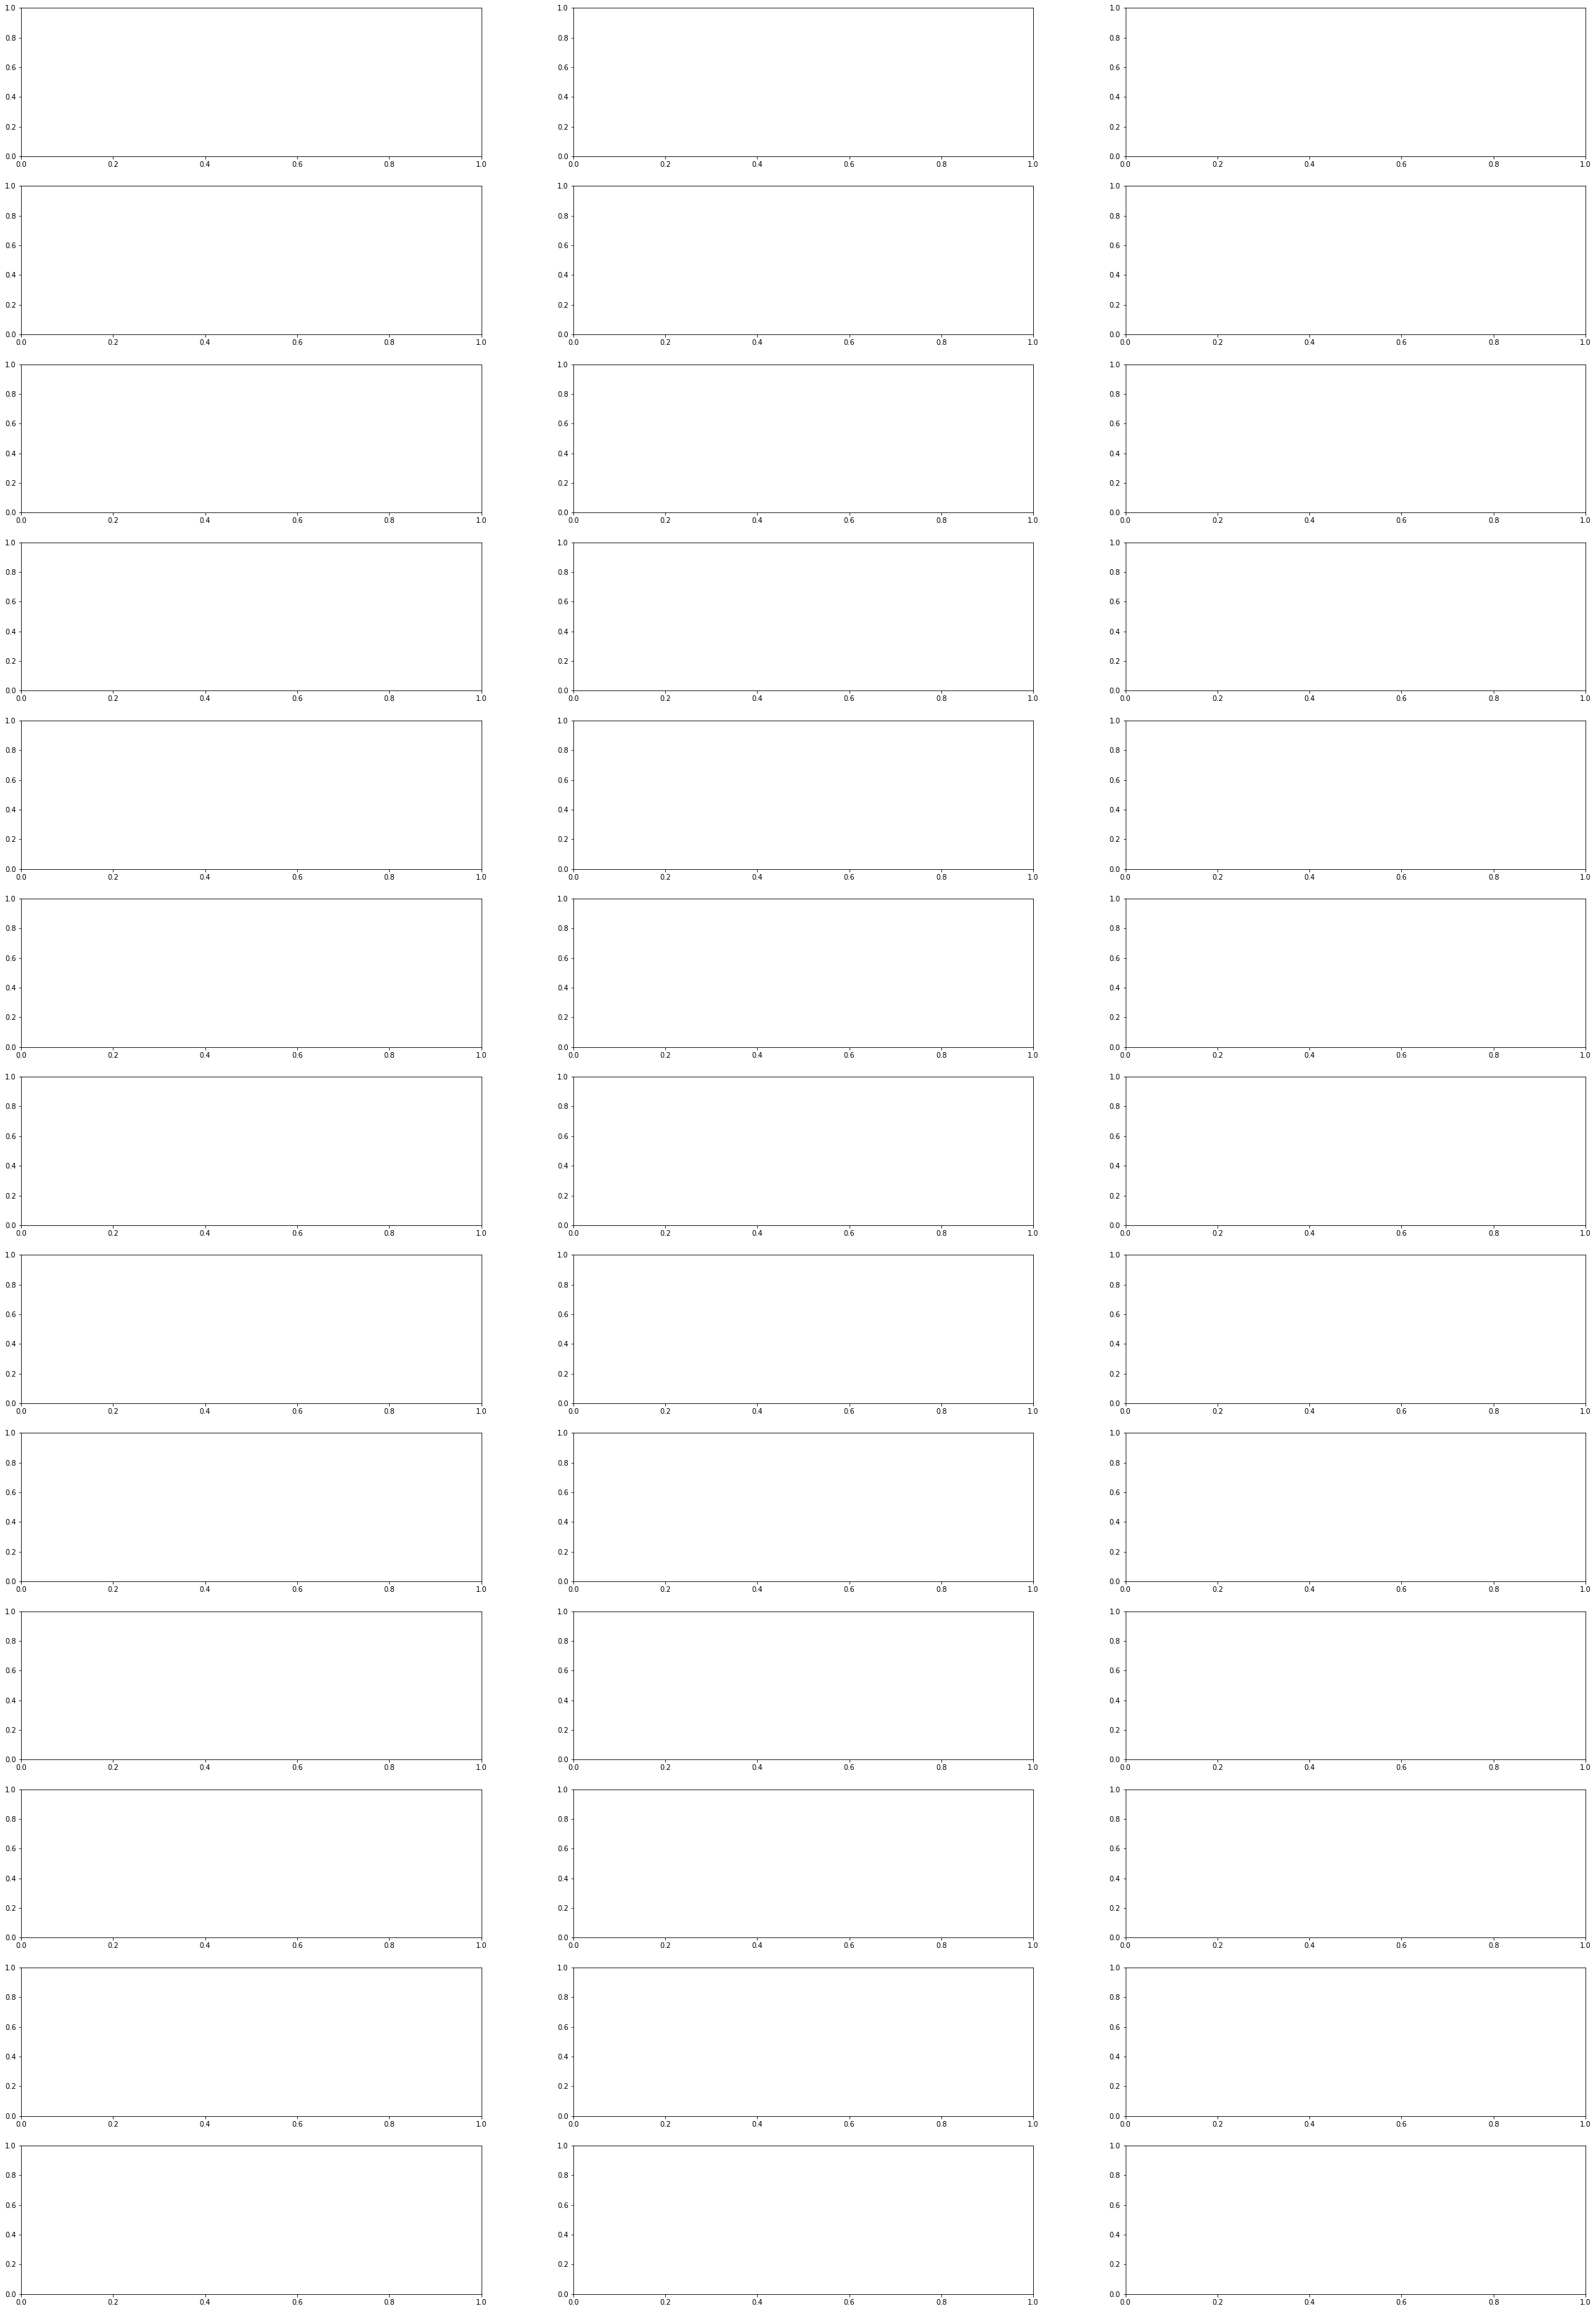

In [32]:
def plot_diffrences():
    fig, axes = plt.subplots(nrows=13, ncols=3, figsize=(40, 60))
    for index, actual in enumerate(y_actuals):
        axes[index][0].plot(0, actual, label="Actual")
        #axes[index][0].plot(linear_reg_predictions, label="Linear")
        axes[index][1].plot(actual, label="Actual")
        #axes[index][1].plot(svm_poly_predictions, label="SVM Poly")
        axes[index][2].plot(actual, label="Actual")
        #axes[index][2].plot(lstm_predictions, label="Lstm")
    plt.show()
    
y_actuals[1].plot()
plot_diffrences()